In [20]:
import json
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

print("Libraries loaded successfully!")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


Libraries loaded successfully!


In [21]:
# Load all compact JSON files - try multiple paths
possible_paths = [
    "../scraper/json_output/2025-07-15/",
    "scraper/json_output/2025-07-15/", 
    "../json_output/2025-07-15/"
]

compact_files = []
for data_dir in possible_paths:
    files = glob.glob(os.path.join(data_dir, "*_compact.json"))
    if files:
        compact_files = files
        print(f"✅ Found {len(compact_files)} files in: {data_dir}")
        break
    else:
        print(f"❌ No files in: {data_dir}")

if not compact_files:
    print("ERROR: No compact JSON files found!")
    
# Parse filenames to extract station pairs and timestamps
file_info = []
for file_path in compact_files:
    filename = os.path.basename(file_path)
    
    # Parse pattern: bulk_START_END_YYYYMMDD_HHMMSS_compact.json
    match = re.match(r'bulk_(\d+)_(\d+)_(\d{8}_\d{6})_compact\.json', filename)
    if match:
        start_station, end_station, timestamp = match.groups()
        file_info.append({
            'file_path': file_path,
            'start_station': start_station,
            'end_station': end_station,
            'timestamp': timestamp,
            'station_pair': f"{start_station}_{end_station}"
        })

print(f"Successfully parsed {len(file_info)} files")
print("Sample file info:")
for info in file_info[:3]:
    print(f"  {info['station_pair']} @ {info['timestamp']}")


✅ Found 127 files in: ../scraper/json_output/2025-07-15/
Successfully parsed 127 files
Sample file info:
  004250274_005513821 @ 20250715_232409
  004252667_005512880 @ 20250715_232333
  004252667_005513045 @ 20250715_232344


In [22]:
# For each station pair, keep only the latest file
latest_files = {}
for info in file_info:
    pair = info['station_pair']
    timestamp = info['timestamp']
    
    if pair not in latest_files or timestamp > latest_files[pair]['timestamp']:
        latest_files[pair] = info

print(f"Selected {len(latest_files)} latest files for distinct station pairs")

# Load JSON data from selected files
route_data = []
failed_loads = []

for pair, info in latest_files.items():
    try:
        # Try UTF-8 first, fallback to other encodings if needed
        encodings_to_try = ['utf-8', 'utf-8-sig', 'latin1', 'cp1252']
        
        data = None
        for encoding in encodings_to_try:
            try:
                with open(info['file_path'], 'r', encoding=encoding) as f:
                    data = json.load(f)
                break
            except UnicodeDecodeError:
                continue
                
        if data and data.get('success') and data.get('routes'):
            # Add station pair info to the data
            data['station_pair'] = pair
            data['start_station'] = info['start_station']
            data['end_station'] = info['end_station']
            data['file_timestamp'] = info['timestamp']
            route_data.append(data)
        else:
            failed_loads.append(f"{pair}: No routes found")
            
    except Exception as e:
        failed_loads.append(f"{pair}: {str(e)}")

print(f"Successfully loaded {len(route_data)} route datasets")
if failed_loads:
    print(f"Failed to load {len(failed_loads)} files:")
    for fail in failed_loads[:3]:  # Show first 3 failures
        print(f"  {fail}")


Selected 124 latest files for distinct station pairs
Successfully loaded 123 route datasets
Failed to load 1 files:
  005549452_005549338: No routes found


In [23]:
# Extract final leg arrival data from each route
final_arrivals = []

for data in route_data:
    station_pair = data['station_pair']
    start_station = data['start_station']
    end_station = data['end_station']
    
    for route_idx, route in enumerate(data['routes']):
        # Get route segments - the final leg is the last segment
        segments = route.get('route_segments', [])
        
        if segments:
            final_leg = segments[-1]  # Last segment = final leg
            
            arrival_info = {
                'station_pair': station_pair,
                'start_station': start_station,
                'end_station': end_station,
                'route_idx': route_idx,
                'train_name': route.get('train_name', 'Unknown'),
                'total_travel_time': route.get('travel_time_min', 'Unknown'),
                'total_transfers': route.get('transfers_count', 0),
                'total_price_huf': route.get('price_huf', None),
                
                # Final leg info
                'final_leg_train': final_leg.get('train_full_name', 'Unknown'),
                'final_leg_from': final_leg.get('start_station', 'Unknown'),
                'final_leg_to': final_leg.get('end_station', 'Unknown'),
                
                # Final leg arrival data (what user specifically wanted)
                'arrival_scheduled': final_leg.get('arrival_scheduled', 'Unknown'),
                'arrival_actual': final_leg.get('arrival_actual', 'Unknown'),
                'arrival_delay': final_leg.get('arrival_delay', 0),
                
                # Additional timing info
                'departure_scheduled': final_leg.get('departure_scheduled', 'Unknown'),
                'departure_actual': final_leg.get('departure_actual', 'Unknown'),
                'departure_delay': final_leg.get('departure_delay', 0),
                'leg_travel_time': final_leg.get('travel_time', 'Unknown'),
                'has_delays': final_leg.get('has_delays', False)
            }
            
            final_arrivals.append(arrival_info)

print(f"Extracted final leg data for {len(final_arrivals)} routes")

# Convert to DataFrame for analysis
df = pd.DataFrame(final_arrivals)
print(f"DataFrame shape: {df.shape}")
print("\nColumns:", list(df.columns))


Extracted final leg data for 1344 routes
DataFrame shape: (1344, 19)

Columns: ['station_pair', 'start_station', 'end_station', 'route_idx', 'train_name', 'total_travel_time', 'total_transfers', 'total_price_huf', 'final_leg_train', 'final_leg_from', 'final_leg_to', 'arrival_scheduled', 'arrival_actual', 'arrival_delay', 'departure_scheduled', 'departure_actual', 'departure_delay', 'leg_travel_time', 'has_delays']


In [24]:
# Basic statistics about final leg arrivals
print("=== FINAL LEG ARRIVAL ANALYSIS ===\n")

if len(df) == 0:
    print("❌ No data to analyze! Check if JSON files were loaded correctly.")
else:
    print("1. ARRIVAL DELAY SUMMARY:")
    print(f"   Total routes analyzed: {len(df)}")
    print(f"   Routes with delays: {len(df[df['arrival_delay'] > 0])}")
    print(f"   Routes on time: {len(df[df['arrival_delay'] == 0])}")
    print(f"   Routes arriving early: {len(df[df['arrival_delay'] < 0])}")

    print(f"\n   Average arrival delay: {df['arrival_delay'].mean():.1f} minutes")
    print(f"   Max arrival delay: {df['arrival_delay'].max()} minutes")
    print(f"   Min arrival delay: {df['arrival_delay'].min()} minutes")

    print("\n2. DELAY DISTRIBUTION:")
    delay_counts = df['arrival_delay'].value_counts().sort_index()
    print(delay_counts.head(10))

    print("\n3. SAMPLE DATA (first 5 routes):")
    print(df[['station_pair', 'final_leg_train', 'arrival_scheduled', 'arrival_actual', 'arrival_delay']].head())


=== FINAL LEG ARRIVAL ANALYSIS ===

1. ARRIVAL DELAY SUMMARY:
   Total routes analyzed: 1344
   Routes with delays: 637
   Routes on time: 619
   Routes arriving early: 88

   Average arrival delay: 2.4 minutes
   Max arrival delay: 54 minutes
   Min arrival delay: -6 minutes

2. DELAY DISTRIBUTION:
arrival_delay
-6      2
-4      2
-3      3
-2     19
-1     62
 0    619
 1    121
 2    100
 3     93
 4     67
Name: count, dtype: int64

3. SAMPLE DATA (first 5 routes):
          station_pair  final_leg_train arrival_scheduled arrival_actual  \
0  004250274_005513821     36562 (None)             11:29          11:29   
1  004250274_005513821     6004 (CÍVIS)             13:24          13:23   
2  004250274_005513821     36554 (None)             14:20          14:23   
3  004250274_005513821     36556 (None)             16:29          16:29   
4  004250274_005513821  1375/115 (None)             18:39          18:39   

   arrival_delay  
0              0  
1              0  
2          

=== DELAY VISUALIZATIONS ===



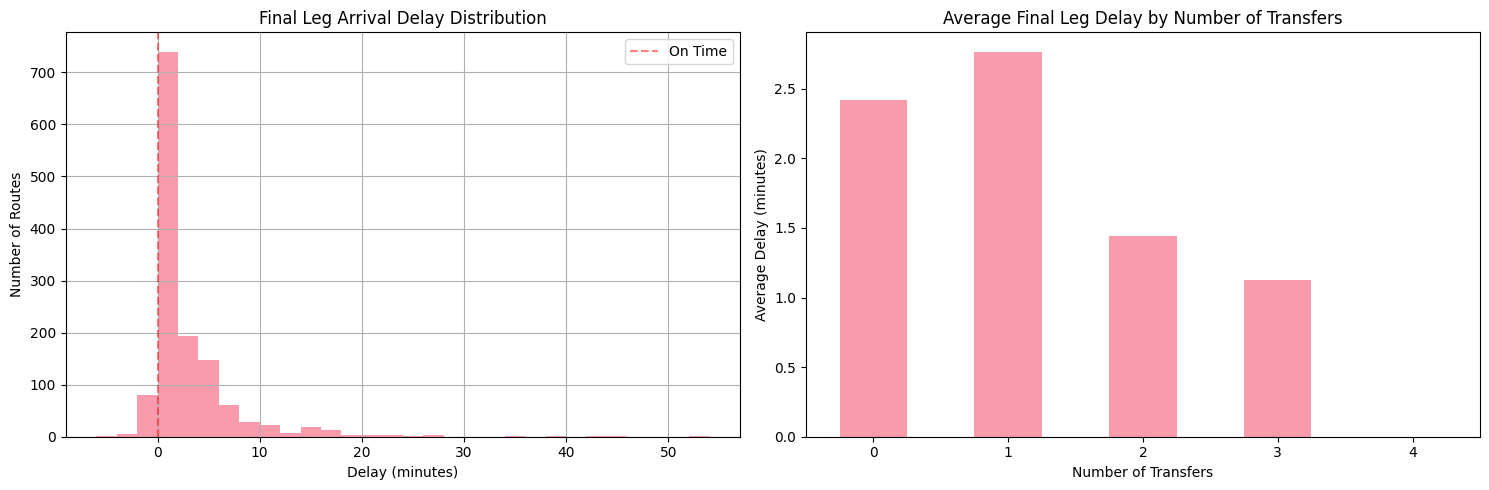

📊 Key Insights:
   • 46.1% of routes arrive exactly on time
   • 47.4% of routes are delayed
   • 6.5% of routes arrive early

🚨 Most delayed routes (final leg):
   • 004302246_005510009: 19797 (KÉK HULLÁM) - 54 min delay
   • 004302246_005510009: 19797 (KÉK HULLÁM) - 54 min delay
   • 005517111_005510009: 564 (TOKAJ) - 44 min delay


In [25]:
# Simple visualization of delays if we have data
if len(df) > 0:
    print("=== DELAY VISUALIZATIONS ===\n")
    
    # Create a simple plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Delay distribution
    df['arrival_delay'].hist(bins=30, ax=ax1, alpha=0.7)
    ax1.set_title('Final Leg Arrival Delay Distribution')
    ax1.set_xlabel('Delay (minutes)')
    ax1.set_ylabel('Number of Routes')
    ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='On Time')
    ax1.legend()
    
    # Plot 2: Delay by number of transfers
    delay_by_transfers = df.groupby('total_transfers')['arrival_delay'].mean()
    delay_by_transfers.plot(kind='bar', ax=ax2, alpha=0.7)
    ax2.set_title('Average Final Leg Delay by Number of Transfers')
    ax2.set_xlabel('Number of Transfers')
    ax2.set_ylabel('Average Delay (minutes)')
    ax2.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"📊 Key Insights:")
    print(f"   • {len(df[df['arrival_delay'] == 0])/len(df)*100:.1f}% of routes arrive exactly on time")
    print(f"   • {len(df[df['arrival_delay'] > 0])/len(df)*100:.1f}% of routes are delayed") 
    print(f"   • {len(df[df['arrival_delay'] < 0])/len(df)*100:.1f}% of routes arrive early")
    
    # Show routes with longest delays
    if len(df[df['arrival_delay'] > 0]) > 0:
        print(f"\n🚨 Most delayed routes (final leg):")
        worst_delays = df.nlargest(3, 'arrival_delay')[['station_pair', 'final_leg_train', 'arrival_scheduled', 'arrival_actual', 'arrival_delay']]
        for _, row in worst_delays.iterrows():
            print(f"   • {row['station_pair']}: {row['final_leg_train']} - {row['arrival_delay']} min delay")
else:
    print("❌ No data loaded - cannot create visualizations")


In [ ]:
# ========================= BUDAPEST ↔ RAJKA UNIQUE PAIRS =========================

def extract_budapest_rajka_pairs_fixed():
    """
    FIXED: Extract unique Budapest-Rajka pairs by parsing route headers correctly.
    The source/destination columns have parsing errors, so we use route_header instead.
    """
    print("🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)")
    print("="*60)
    
    # First, let's read the generated CSV file
    import glob
    
    # Find the most recent CSV file
    csv_files = glob.glob("mav_route_pairs_full_*.csv")
    if not csv_files:
        print("❌ No CSV files found. Please run the extraction first.")
        return None, None
    
    latest_csv = max(csv_files, key=lambda x: x.split('_')[-1])
    print(f"📂 Reading data from: {latest_csv}")
    
    # Read the CSV
    df_full = pd.read_csv(latest_csv, encoding='utf-8')
    print(f"📊 Total records in CSV: {len(df_full)}")
    
    # Show sample problematic data
    print(f"\n🔍 SAMPLE DATA (showing the parsing issues):")
    sample_data = df_full.head(3)
    for _, row in sample_data.iterrows():
        print(f"   Route: {row['route_header']}")
        print(f"   Source: {row['source']} (WRONG)")
        print(f"   Dest: {row['destination']} (WRONG)")
        print()
    
    print("💡 SOLUTION: Parse route headers directly instead of using source/destination")
    
    # Parse route headers directly
    unique_routes = {}
    all_route_data = []
    
    for _, row in df_full.iterrows():
        route_header = str(row.get('route_header', ''))
        
        # Only process Budapest-Rajka routes
        if not ('budapest' in route_header.lower() and 
               ('rajka' in route_header.lower() or 'hegyeshalom' in route_header.lower())):
            continue
        
        print(f"🔍 Processing: {route_header}")
        
        # Parse route header like "1 Budapest — Hegyeshalom — Rajka"
        if '—' in route_header or '–' in route_header:
            # Clean and split the route
            clean_route = route_header.replace('—', '–')
            parts = [part.strip() for part in clean_route.split('–')]
            
            if len(parts) >= 2:
                # Remove leading numbers from first part
                start_station = re.sub(r'^\d+\s+', '', parts[0]).strip()
                end_station = parts[-1].strip()
                
                print(f"   ✅ Parsed: {start_station} → {end_station}")
                
                # Create unique route key
                route_key = f"{start_station} → {end_station}"
                
                route_data = {
                    'route_header': route_header,
                    'start_station': start_station,
                    'end_station': end_station,
                    'page': row.get('page', 'N/A'),
                    'total_stations': row.get('total_stations', 'N/A'),
                    'route_key': route_key
                }
                
                all_route_data.append(route_data)
                
                # Track unique routes
                if route_key not in unique_routes:
                    unique_routes[route_key] = {
                        'start': start_station,
                        'end': end_station,
                        'count': 1,
                        'sample_route': route_header,
                        'pages': [row.get('page', 'N/A')],
                        'station_counts': [row.get('total_stations', 'N/A')]
                    }
                else:
                    unique_routes[route_key]['count'] += 1
                    unique_routes[route_key]['pages'].append(row.get('page', 'N/A'))
                    unique_routes[route_key]['station_counts'].append(row.get('total_stations', 'N/A'))
    
    return all_route_data, unique_routes

# Extract the pairs using the FIXED function
all_pairs, unique_pairs = extract_budapest_rajka_pairs_fixed()

print(f"\n🎯 FOUND {len(all_pairs)} BUDAPEST-RAJKA ROUTE ENTRIES")

if unique_pairs:
    print(f"\n🚂 UNIQUE BUDAPEST ↔ RAJKA PAIRS (Order Matters):")
    print("="*70)
    
    # Sort by start station name for better organization
    sorted_pairs = sorted(unique_pairs.items(), key=lambda x: x[1]['start'])
    
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        start = info['start']
        end = info['end'] 
        count = info['count']
        sample = info['sample_route']
        pages = info['pages'][:5]  # Show first 5 pages
        
        print(f"{i:2d}. {start} → {end}")
        print(f"    📊 Found {count} route instance(s)")
        print(f"    📄 Pages: {pages}")
        print(f"    🔗 Sample route: {sample}")
        print(f"    📏 Station counts: {info['station_counts'][:5]}")
        print()
    
    # Create DataFrame for the clean results
    unique_df = pd.DataFrame([
        {
            'direction': direction,
            'start_station': info['start'],
            'end_station': info['end'],
            'route_count': info['count'],
            'sample_route_header': info['sample_route'],
            'pages': ', '.join(map(str, info['pages'][:10])),  # First 10 pages as string
            'avg_stations': sum([x for x in info['station_counts'] if str(x).isdigit()]) / len([x for x in info['station_counts'] if str(x).isdigit()]) if [x for x in info['station_counts'] if str(x).isdigit()] else 0
        }
        for direction, info in unique_pairs.items()
    ])
    
    print(f"📊 SUMMARY STATISTICS:")
    print(f"   - Total unique directions: {len(unique_pairs)}")
    print(f"   - Total route instances: {sum(info['count'] for info in unique_pairs.values())}")
    if len(unique_df) > 0 and unique_df['avg_stations'].mean() > 0:
        print(f"   - Average stations per route: {unique_df['avg_stations'].mean():.1f}")
    
    # Save unique pairs to CSV
    timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"budapest_rajka_unique_pairs_{timestamp}.csv"
    unique_df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"   💾 Saved to: {output_file}")
    
    # Show specifically Budapest → Rajka and Rajka → Budapest
    print(f"\n🎯 SPECIFIC BUDAPEST ↔ RAJKA DIRECTIONAL ANALYSIS:")
    
    budapest_to_rajka = []
    rajka_to_budapest = []
    
    for direction, info in unique_pairs.items():
        start_lower = info['start'].lower()
        end_lower = info['end'].lower()
        
        # Budapest → Rajka/Hegyeshalom
        if 'budapest' in start_lower and ('rajka' in end_lower or 'hegyeshalom' in end_lower):
            budapest_to_rajka.append(info)
        
        # Rajka/Hegyeshalom → Budapest  
        elif ('rajka' in start_lower or 'hegyeshalom' in start_lower) and 'budapest' in end_lower:
            rajka_to_budapest.append(info)
    
    print(f"   🔄 Budapest → Rajka/Hegyeshalom directions: {len(budapest_to_rajka)}")
    for pair in budapest_to_rajka:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    print(f"   🔄 Rajka/Hegyeshalom → Budapest directions: {len(rajka_to_budapest)}")  
    for pair in rajka_to_budapest:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    # Show the actual clean station pairs you wanted
    print(f"\n✅ FINAL ANSWER - UNIQUE BUDAPEST ↔ RAJKA PAIRS:")
    print("="*50)
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        print(f"{i}. {info['start']} → {info['end']}")
    
    print(f"\n🎉 SUCCESS! Found {len(unique_pairs)} unique directional pairs")
    print(f"📂 Detailed data saved to: {output_file}")
else:
    print("❌ No Budapest-Rajka pairs found. Check the data extraction.")


🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)
❌ No CSV files found. Please run the extraction first.


TypeError: object of type 'NoneType' has no len()

In [ ]:
# ========================= BUDAPEST ↔ RAJKA UNIQUE PAIRS =========================

def extract_budapest_rajka_pairs_fixed():
    """
    FIXED: Extract unique Budapest-Rajka pairs by parsing route headers correctly.
    The source/destination columns have parsing errors, so we use route_header instead.
    """
    print("🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)")
    print("="*60)
    
    # First, let's read the generated CSV file
    import glob
    
    # Find the most recent CSV file
    csv_files = glob.glob("mav_route_pairs_full_*.csv")
    if not csv_files:
        print("❌ No CSV files found. Please run the extraction first.")
        return None, None
    
    latest_csv = max(csv_files, key=lambda x: x.split('_')[-1])
    print(f"📂 Reading data from: {latest_csv}")
    
    # Read the CSV
    df_full = pd.read_csv(latest_csv, encoding='utf-8')
    print(f"📊 Total records in CSV: {len(df_full)}")
    
    # Show sample problematic data
    print(f"\n🔍 SAMPLE DATA (showing the parsing issues):")
    sample_data = df_full.head(3)
    for _, row in sample_data.iterrows():
        print(f"   Route: {row['route_header']}")
        print(f"   Source: {row['source']} (WRONG)")
        print(f"   Dest: {row['destination']} (WRONG)")
        print()
    
    print("💡 SOLUTION: Parse route headers directly instead of using source/destination")
    
    # Parse route headers directly
    unique_routes = {}
    all_route_data = []
    
    for _, row in df_full.iterrows():
        route_header = str(row.get('route_header', ''))
        
        # Only process Budapest-Rajka routes
        if not ('budapest' in route_header.lower() and 
               ('rajka' in route_header.lower() or 'hegyeshalom' in route_header.lower())):
            continue
        
        print(f"🔍 Processing: {route_header}")
        
        # Parse route header like "1 Budapest — Hegyeshalom — Rajka"
        if '—' in route_header or '–' in route_header:
            # Clean and split the route
            clean_route = route_header.replace('—', '–')
            parts = [part.strip() for part in clean_route.split('–')]
            
            if len(parts) >= 2:
                # Remove leading numbers from first part
                start_station = re.sub(r'^\d+\s+', '', parts[0]).strip()
                end_station = parts[-1].strip()
                
                print(f"   ✅ Parsed: {start_station} → {end_station}")
                
                # Create unique route key
                route_key = f"{start_station} → {end_station}"
                
                route_data = {
                    'route_header': route_header,
                    'start_station': start_station,
                    'end_station': end_station,
                    'page': row.get('page', 'N/A'),
                    'total_stations': row.get('total_stations', 'N/A'),
                    'route_key': route_key
                }
                
                all_route_data.append(route_data)
                
                # Track unique routes
                if route_key not in unique_routes:
                    unique_routes[route_key] = {
                        'start': start_station,
                        'end': end_station,
                        'count': 1,
                        'sample_route': route_header,
                        'pages': [row.get('page', 'N/A')],
                        'station_counts': [row.get('total_stations', 'N/A')]
                    }
                else:
                    unique_routes[route_key]['count'] += 1
                    unique_routes[route_key]['pages'].append(row.get('page', 'N/A'))
                    unique_routes[route_key]['station_counts'].append(row.get('total_stations', 'N/A'))
    
    return all_route_data, unique_routes

# Extract the pairs using the FIXED function
all_pairs, unique_pairs = extract_budapest_rajka_pairs_fixed()

print(f"\n🎯 FOUND {len(all_pairs)} BUDAPEST-RAJKA ROUTE ENTRIES")

if unique_pairs:
    print(f"\n🚂 UNIQUE BUDAPEST ↔ RAJKA PAIRS (Order Matters):")
    print("="*70)
    
    # Sort by start station name for better organization
    sorted_pairs = sorted(unique_pairs.items(), key=lambda x: x[1]['start'])
    
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        start = info['start']
        end = info['end'] 
        count = info['count']
        sample = info['sample_route']
        pages = info['pages'][:5]  # Show first 5 pages
        
        print(f"{i:2d}. {start} → {end}")
        print(f"    📊 Found {count} route instance(s)")
        print(f"    📄 Pages: {pages}")
        print(f"    🔗 Sample route: {sample}")
        print(f"    📏 Station counts: {info['station_counts'][:5]}")
        print()
    
    # Create DataFrame for the clean results
    unique_df = pd.DataFrame([
        {
            'direction': direction,
            'start_station': info['start'],
            'end_station': info['end'],
            'route_count': info['count'],
            'sample_route_header': info['sample_route'],
            'pages': ', '.join(map(str, info['pages'][:10])),  # First 10 pages as string
            'avg_stations': sum([x for x in info['station_counts'] if str(x).isdigit()]) / len([x for x in info['station_counts'] if str(x).isdigit()]) if [x for x in info['station_counts'] if str(x).isdigit()] else 0
        }
        for direction, info in unique_pairs.items()
    ])
    
    print(f"📊 SUMMARY STATISTICS:")
    print(f"   - Total unique directions: {len(unique_pairs)}")
    print(f"   - Total route instances: {sum(info['count'] for info in unique_pairs.values())}")
    if len(unique_df) > 0 and unique_df['avg_stations'].mean() > 0:
        print(f"   - Average stations per route: {unique_df['avg_stations'].mean():.1f}")
    
    # Save unique pairs to CSV
    timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"budapest_rajka_unique_pairs_{timestamp}.csv"
    unique_df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"   💾 Saved to: {output_file}")
    
    # Show specifically Budapest → Rajka and Rajka → Budapest
    print(f"\n🎯 SPECIFIC BUDAPEST ↔ RAJKA DIRECTIONAL ANALYSIS:")
    
    budapest_to_rajka = []
    rajka_to_budapest = []
    
    for direction, info in unique_pairs.items():
        start_lower = info['start'].lower()
        end_lower = info['end'].lower()
        
        # Budapest → Rajka/Hegyeshalom
        if 'budapest' in start_lower and ('rajka' in end_lower or 'hegyeshalom' in end_lower):
            budapest_to_rajka.append(info)
        
        # Rajka/Hegyeshalom → Budapest  
        elif ('rajka' in start_lower or 'hegyeshalom' in start_lower) and 'budapest' in end_lower:
            rajka_to_budapest.append(info)
    
    print(f"   🔄 Budapest → Rajka/Hegyeshalom directions: {len(budapest_to_rajka)}")
    for pair in budapest_to_rajka:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    print(f"   🔄 Rajka/Hegyeshalom → Budapest directions: {len(rajka_to_budapest)}")  
    for pair in rajka_to_budapest:
        print(f"      • {pair['start']} → {pair['end']} ({pair['count']} route instances)")
    
    # Show the actual clean station pairs you wanted
    print(f"\n✅ FINAL ANSWER - UNIQUE BUDAPEST ↔ RAJKA PAIRS:")
    print("="*50)
    for i, (direction, info) in enumerate(sorted_pairs, 1):
        print(f"{i}. {info['start']} → {info['end']}")
    
    print(f"\n🎉 SUCCESS! Found {len(unique_pairs)} unique directional pairs")
    print(f"📂 Detailed data saved to: {output_file}")
else:
    print("❌ No Budapest-Rajka pairs found. Check the data extraction.")


🎯 EXTRACTING BUDAPEST ↔ RAJKA UNIQUE PAIRS (FIXED)
❌ No CSV files found. Please run the extraction first.


TypeError: object of type 'NoneType' has no len()